# Custom augmentations with arithmetic operations

This notebook shows how to implement a custom augmentation using expressions with arithmetic operations in `define_graph` part of the DALI Pipeline.

## Blending images

We will create pipeline that will blend images in a few different ways. To easily visualize the results, we created two separate file lists for our reader - `cats.txt` and `dogs.txt` that contain pictures of cats and dogs.


#### Imports

Lets start with necessary imports.

In [1]:
from __future__ import division
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
from nvidia.dali.types import Constant

### Operators used explicitly
We don't need to explicitly list arithmetic operators that we want to use in the Pipeline constructor. They work as regular Python operators in the `define_graph` step. 

As for the rest of Operators, our pipeline will use two separate FileReaders to crate two separate batches of tensors, one with cats and one with dogs.
We also need an ImageDecoder to decode the loaded images.

Next we need Resize Operator for both inputs - the arithmetic operators are applying pointwise operations between tensors and require them to have matching shape and size. We will settle for 400 x 400 images.

The last operator that we may want to declare in the Pipeline constructor is a Cast operator to convert the data back into desired type.

### The graph with custom augmentation

Let's proceed to `define_graph`. The first few steps are quite obvious:
* Load both input batches
* Decode both inputs
* Resize the inputs to equal sizes

Now we have two variables `dogs` and `cats` representing two batches of equal-sized images. 
Let's blend those images with some weights using a formula:
```
(0.4 * cats + 0.6 * dogs) / 2
```
Here we used python immidiate values as constant inputs to our arithmetic expression.

#### Using dali.types.Constant to indicate type
We can also be more conscious about the types that we use, and do all of the computations in `uint16`.

As our inputs are in `uint8`, doing computations with a constant marked as `uint16` will promote the results to `uint16` (for details of type promotions see "DALI expressions and arithmetic operators" tutorial).
We will also use `//` division that allows us to keep the integer type of the result.

```
(Constant(4).uint16() * cats + Constant(6).uint16() * dogs) // Constant(20).uint16()
```

As the last step we return both of the inputs and the results casted back to `uint8`.

In [2]:
class BlendPipeline(Pipeline):                   
    def __init__(self, batch_size, num_threads, device_id):
        super(BlendPipeline, self).__init__(batch_size, num_threads, device_id, seed=42)
        self.input_dogs = ops.FileReader(device="cpu", file_root="../images", file_list="dogs.txt")
        self.input_cats = ops.FileReader(device="cpu", file_root="../images", file_list="cats.txt")
        self.decode = ops.ImageDecoder(device="cpu", output_type=types.RGB)
        self.resize = ops.Resize(resize_x=400, resize_y=400)
        self.uint8 = ops.Cast(dtype=types.DALIDataType.UINT8)
    
    def define_graph(self):
        cats_buf, _ = self.input_cats()
        dogs_buf, _ = self.input_dogs()
        images = self.decode([cats_buf, dogs_buf])
        cats, dogs = self.resize(images)
        blend_float = (0.4 * cats + 0.6 * dogs) / 2
        blend_uint16 = (Constant(4).uint16() * cats + Constant(6).uint16() * dogs) // Constant(20).uint16()
        return cats, dogs, self.uint8(blend_float), self.uint8(blend_uint16)

### Running the pipeline

Lets create an instance of the pipelie and build it. We use `batch_size = 1` for simplicity of showing the result.

In [3]:
pipe = BlendPipeline(batch_size=1, num_threads=1, device_id=0)
pipe.build()

We will use simple helper function to show the images. In case of bigger batches, `data_idx` can be adjusted to show different samples.
The `output_titles` will be used to set the titles of the Pipeline output.

In [4]:
import matplotlib.pyplot as plt

def display(output, titles, cpu = True):
    data_idx = 0
    fig, axes = plt.subplots(len(output) // 2, 2, figsize=(15, 15))
    if len(output) == 1:
        axes = [axes]
    for i, out in enumerate(output):
        img = out.at(data_idx) if cpu else out.as_cpu().at(data_idx)
        axes[i // 2, i % 2].imshow(img);
        axes[i // 2, i % 2].axis('off')
        axes[i // 2, i % 2].set_title(titles[i])

output_titles = [
        "Cat", "Dog", 
        "(0.4 * Cat + 0.6 * Dog) / 2", 
        "(Constant(4).uint16() * Cat + Constant(6).uint16() * Dog) // Constant(20).uint16()"]

Now, we wil run and display the results. You can play this cell several times to see the result for different images.

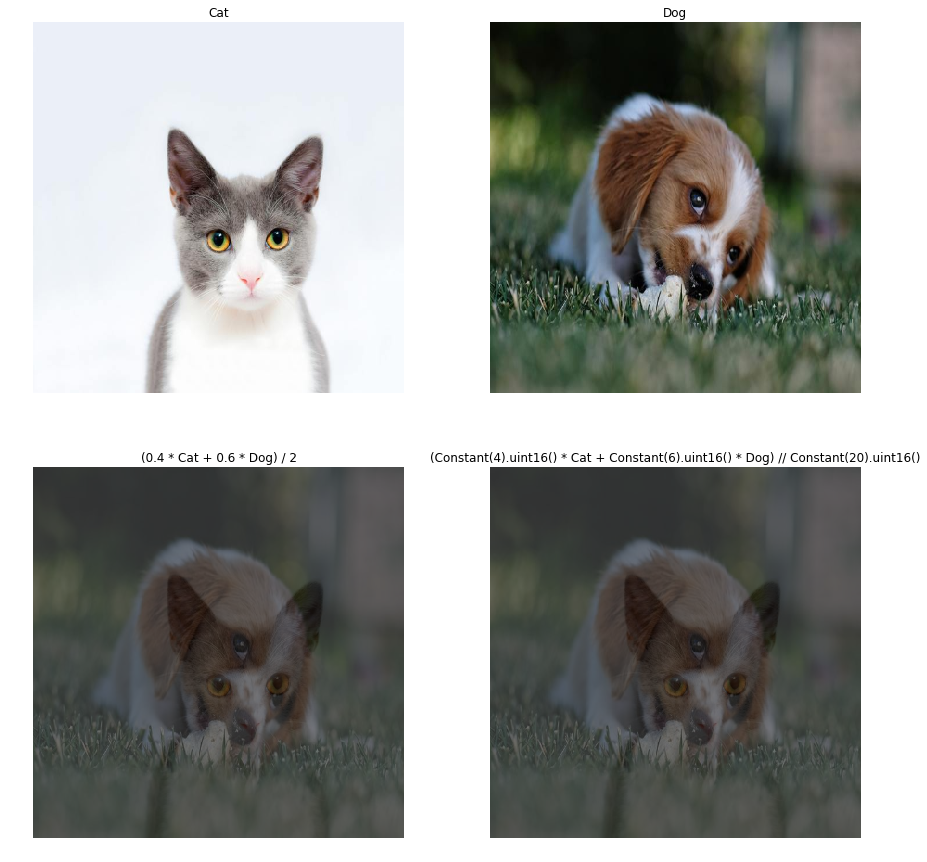

In [6]:
output = pipe.run()
display(output, output_titles)